In [1]:
import os, sys
import ROOT as rt
import json
## user define
sys.path.append(".")
sys.path.append("./Utils")
from SystHelper import *
from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector
setting={}
with open('config/Settrain.json') as json_file:
    data = json.load(json_file)
    setting=data
    
INPUTDIR = sys.argv[1]
ERA = sys.argv[2]
REGION = sys.argv[3]
ONLY_BENCHMARK = sys.argv[4]
ALL_MASSES = setting["ALL_MASSES"]
# # for dev
# INPUTDIR = "/eos/user/h/hkwon/SWAN_projects/Zpeak/Outputs/DNN/"
# INPUTDIR = "/eos/user/h/hkwon/Run2/Preselection/20231214GEv1/DNN/"
# ERA = "mm17"
# INPUTDIR += ERA
# REGION = "SR"
# ONLY_BENCHMARK = 'yes'

Welcome to JupyROOT 6.28/06


In [2]:
def get_str_lumi_channel(era):
    if("mm" in era):
        str_channel="#mu#mu"          
    if("ee" in era):
        str_channel="ee"               
    if("em" in era):
        str_channel="e#mu"
    if "16" in era:
        str_lumi="37.33"
    if "16pre" in era:
        str_lumi="19.52" 
    if "16post" in era:
        str_lumi="16.81"                 
    if "17" in era:
        str_lumi="41.48"
    if "18" in era:
        str_lumi="59.83"
    return str_channel, str_lumi

In [3]:
out_dir = "Outputs/Syst/"+ERA+"/"+REGION

os.system("mkdir -p "+out_dir+"/AN")
os.system("mkdir -p "+out_dir+"/root_files")

def draw_sys_ratio(ERA, f, process, list_sys, mass, updown="Up", smoothed = False):
#     f.ls()
    str_channel, str_lumi = get_str_lumi_channel(ERA)
    c=rt.TCanvas("", "", 800, 800)
    c.SetGrid()
    c.SetLeftMargin(0.12)
#     c.SetRightMargin(0.3)
    rt.gStyle.SetPalette(rt.kRainBow)
    rt.gStyle.SetOptStat(0)
    l = rt.TLegend(0.6,0.7,0.89,0.89)
    l.SetBorderSize(0)
    h_nom = f.Get("signal_region/"+process)
    n_h_nom = h_nom.Integral()
    list_hist=[] # kind of hack..(?) hist object seems to remain to the end
    list_hist_clone=[]
    for s in list_sys:
        h = f.Get("signal_region/"+process+"_"+s+updown)
        list_hist.append(h)
        h_new = h.Clone("")
        list_hist_clone.append(h_new)
        h_new.SetTitle("")
        h_new.GetYaxis().SetTitle("Sys/Nom")
        h_new.GetXaxis().SetTitle("DNN score")
        h_new.SetLineWidth(3)
        h_new.SetFillColor(0)
        h_new.Divide(h_nom)
        if "btag" in s:
            h_cor = f.Get("signal_region/"+process+"_btagSFbc_correlated"+updown)
            list_hist.append(h_cor)
            h_cor_new = h_cor.Clone("")
            list_hist_clone.append(h_cor_new)
            h_cor_new.Divide(h_nom)
            uncor = []
            cor = []            
            for i in range(h_nom.GetNbinsX()):
                uncor.append(1-h_new.GetBinContent(i+1))
                cor.append(1-h_cor_new.GetBinContent(i+1))   
            quad = np.sqrt(np.array(uncor)*np.array(uncor) + np.array(cor)*np.array(cor))
            # overwrite 
            for i in range(h_nom.GetNbinsX()):   
                if "Up" in updown:
                    h_new.SetBinContent(i+1, 1+quad[i])
                else:                        
                    h_new.SetBinContent(i+1, 1-quad[i])
        n_h_new = h_new.Integral()/h_nom.GetNbinsX()
        eff = n_h_new        
        if not "met" in s and not "hdamp" in s and not "UE" in s and not "scale" in s and not "JES" in s or smoothed==False:
            l.AddEntry(h_new, s+" "+updown+" (avg. "+str(round((eff-1),2)*100)+"%)", "l")
            l.SetTextSize(0.02)
            h_new.GetYaxis().SetRangeUser(0.8, 1.2)
            h_new.Draw("plc same hist")
        else:
            h = f.Get("signal_region/"+process+"_"+s+"_smoothed"+updown)
            list_hist.append(h)
            h_new = h.Clone("")
            list_hist_clone.append(h_new)
            h_new.SetTitle("")
            h_new.GetYaxis().SetTitle("Sys/Nom")
            h_new.GetXaxis().SetTitle("DNN score")
            h_new.SetLineWidth(3)
            h_new.SetFillColor(0)
            n_h_new = h_new.Integral()
            eff = n_h_new/n_h_nom
            h_new.Divide(h_nom)
            if not "JEC" in s: 
                l.AddEntry(h_new, s+" smoothed "+updown+" (avg. "+str(round((eff-1),2)*100)+"%)", "l")
            else:            
                l.AddEntry(h_new, s+" "+updown+" (avg. "+str(round((eff-1),2)*100)+"%)", "l")
            l.SetTextSize(0.02)
            h_new.GetYaxis().SetRangeUser(0.8, 1.2)
            h_new.Draw("plc same hist")            
            
    l.Draw()
    latex=rt.TLatex()
    latex.DrawLatexNDC( 0.43,0.85, "#scale[0.8]{#font[42]{"+process+"}}") 
    latex.DrawLatexNDC(0.71, 0.92, "#font[42]{#scale[0.8]{"+str_lumi+" fb^{-1}(13 TeV)}}");
    latex.DrawLatexNDC(0.13, 0.92, "#font[62]{CMS}#font[42]{#it{#scale[0.8]{ Preliminary}}}");
    latex.DrawLatexNDC(0.15,0.85, "#scale[0.8]{#font[42]{"+str_channel+" channel}}") 
    c.Draw()
    if smoothed==True and mass=="Zp-2500_CH-345":
        c.SaveAs(out_dir+"/AN/"+mass+process+updown+"_syst_by_process.pdf")
    else:
        c.SaveAs(out_dir+"/"+mass+process+updown+"_syst_by_process.pdf")
    return c

In [31]:
import math
def draw_sys_ratio_bysource(ERA, f, processes, s, mass, smoothed = False):
#     f.ls()
    str_channel, str_lumi = get_str_lumi_channel(ERA)
    c=rt.TCanvas("", "", 800, 800)
    c.SetGrid()
    c.SetLeftMargin(0.12)
#     c.SetRightMargin(0.3)
    rt.gStyle.SetPalette(rt.kRainBow)
    rt.gStyle.SetOptStat(0)
    l = rt.TLegend(0.7,0.7,0.89,0.89)
    l.SetBorderSize(0)

    list_hist=[] # kind of hack..(?) hist object seems to remain to the end
    list_hist_clone=[]
    dic_smooth={}
    for i, process in enumerate(processes):
        h_nom = f.Get("signal_region/"+process)            
        if not "mu_scale" in s and not "mu_res" in s:
            h_u = f.Get("signal_region/"+process+"_"+s+"Up")
            h_d = f.Get("signal_region/"+process+"_"+s+"Down")
            list_hist.append(h_u)
            list_hist.append(h_d)
            h_u_new = h_u.Clone("")
            h_d_new = h_d.Clone("")
            list_hist_clone.append(h_u_new)
            list_hist_clone.append(h_d_new)              
            h_u_new.SetTitle("")
            h_u_new.GetYaxis().SetTitle("Sys/Nom")
            h_u_new.GetXaxis().SetTitle("DNN score")
            h_u_new.SetLineWidth(2)
            h_d_new.SetLineWidth(2)
            h_u_new.SetLineStyle(1)
            h_d_new.SetLineStyle(2)    
            h_u_new.SetLineColor(i+1)
            h_d_new.SetLineColor(i+1) 
            h_u_new.Divide(h_nom)
            h_d_new.Divide(h_nom)
        if "btag" in s:
            h_cor_u = f.Get("signal_region/"+process+"_btagSFbc_correlatedUp")
            h_cor_d = f.Get("signal_region/"+process+"_btagSFbc_correlatedDown")  
            list_hist.append(h_cor_u)
            list_hist.append(h_cor_d)
            h_cor_u_new = h_cor_u.Clone("")
            h_cor_d_new = h_cor_d.Clone("")
            list_hist_clone.append(h_cor_u_new)
            list_hist_clone.append(h_cor_d_new)  
            h_cor_u_new.Divide(h_nom)
            h_cor_d_new.Divide(h_nom)  
            uncor_u = []
            cor_u = []            
            uncor_d = []
            cor_d = []
            for i in range(h_nom.GetNbinsX()):
                uncor_u.append(1-h_u_new.GetBinContent(i+1))
                cor_u.append(1-h_cor_u_new.GetBinContent(i+1))                
                uncor_d.append(1-h_d_new.GetBinContent(i+1))
                cor_d.append(1-h_cor_d_new.GetBinContent(i+1))
            quad_u = np.sqrt(np.array(uncor_u)*np.array(uncor_u) + np.array(cor_u)*np.array(cor_u))
            quad_d = np.sqrt(np.array(uncor_d)*np.array(uncor_d) + np.array(cor_d)*np.array(cor_d))
            # overwrite 
            for i in range(h_nom.GetNbinsX()):           
                h_u_new.SetBinContent(i+1, 1+quad_u[i])
                h_d_new.SetBinContent(i+1, 1-quad_d[i])
            print("uncor:", uncor_u)
            print("cor:", cor_u)
            print("quad u:", quad_u)
            print("h_u_new:", h_u_new.GetBinContent(1))

#         if not "met" in s and not "hdamp" in s and not "UE" in s and not "scale" in s and not "JES" in s and not "fsr" in s and not "isr" in s and not "mu_scale" in s and not "mu_res" in s or smoothed==False:
        if not "met" in s and not "hdamp" in s and not "UE" in s and not "scale" in s and not "JES" in s and not "fsr" in s and not "isr" in s and not "mu_scale" in s and not "mu_res" in s or smoothed==False:
            l.AddEntry(h_u_new, process+" "+s+" Up", "l")
            l.AddEntry(h_d_new, process+" "+s+" Down", "l")
            h_u_new.GetYaxis().SetRangeUser(0.8, 1.3)
            h_u_new.Draw("same hist")
            h_d_new.Draw("same hist")
            if "scale" in s and "e" in ERA:
                h_nom_data = f.Get("signal_region/data_obs")
                h_u_data = f.Get("signal_region/data_"+s+"Up")
                h_d_data = f.Get("signal_region/data_"+s+"Down")
                list_hist.append(h_u_data)
                list_hist.append(h_d_data)
                h_u_data_new = h_u_data.Clone("")
                h_d_data_new = h_d_data.Clone("")
                list_hist_clone.append(h_u_data_new)
                list_hist_clone.append(h_d_data_new)
                h_u_data_new.Divide(h_nom_data)
                h_d_data_new.Divide(h_nom_data)
                h_u_new.Divide(h_u_data_new)
                h_d_new.Divide(h_d_data_new)
            w, w_data, yup, ydown = [[] for _ in range(4)]
            # fill dictionary
            for nb in range(h_d_new.GetNbinsX()):
                w.append(h_nom.GetBinContent(nb+1))  
                if "scale" in s and "e" in ERA:
                    w_data.append(h_nom_data.GetBinContent(nb+1))  
                yup.append(h_u_new.GetBinContent(nb+1)) 
                ydown.append(h_d_new.GetBinContent(nb+1))  

            dic_smooth[process+s+"Nom"] = w
            dic_smooth[process+s+"NomData"] = w_data
            dic_smooth[process+s+"Up"] = yup
            dic_smooth[process+s+"Down"] = ydown 
        
        else:
            h_smoothed_u = f.Get("signal_region/"+process+"_"+s+"_smoothedUp")
            h_smoothed_d = f.Get("signal_region/"+process+"_"+s+"_smoothedDown")
            print("signal_region/"+process+"_"+s+"_smoothedDown")
            list_hist.append(h_smoothed_u)
            list_hist.append(h_smoothed_d)
            h_smoothed_u_new = h_smoothed_u.Clone("")
            h_smoothed_d_new = h_smoothed_d.Clone("")
            list_hist_clone.append(h_smoothed_u_new)
            list_hist_clone.append(h_smoothed_d_new)
            h_smoothed_u_new.Divide(h_nom)
            h_smoothed_d_new.Divide(h_nom)
            h_smoothed_u_new.SetTitle("")
            h_smoothed_u_new.GetYaxis().SetTitle("Sys/Nom")
            h_smoothed_u_new.GetXaxis().SetTitle("DNN score")            
            h_smoothed_u_new.SetLineWidth(2)    
            h_smoothed_d_new.SetLineWidth(2)    
            h_smoothed_u_new.SetLineStyle(1)    
            h_smoothed_d_new.SetLineStyle(2)    
            h_smoothed_u_new.SetLineColor(i+1)
            h_smoothed_d_new.SetLineColor(i+1)
            h_smoothed_u_new.GetYaxis().SetRangeUser(0.8, 1.3)
            l.AddEntry(h_smoothed_u_new, process+" "+s+" smoothed Up", "l")
            l.AddEntry(h_smoothed_d_new, process+" "+s+" smoothed Down", "l")
            h_smoothed_u_new.Draw("same hist")
            h_smoothed_d_new.Draw("same hist")
             

                
    l.Draw()
    latex=rt.TLatex()
    latex.DrawLatexNDC(0.71, 0.92, "#font[42]{#scale[0.8]{"+str_lumi+" fb^{-1}(13 TeV)}}");
    latex.DrawLatexNDC(0.13, 0.92, "#font[62]{CMS}#font[42]{#it{#scale[0.8]{ Preliminary}}}");
    latex.DrawLatexNDC(0.15,0.85, "#scale[0.8]{#font[42]{"+str_channel+" channel}}") 
    
#     latex.DrawLatexNDC( 0.13,0.85, "#scale[0.8]{#font[42]{}}")    
    c.Draw()
    if smoothed==True:
#     if smoothed==True and mass=="Zp-2500_CH-345":
        c.SaveAs(out_dir+"/AN/"+mass+s+"_syst_by_source.pdf")
    else:
        c.SaveAs(out_dir+"/"+mass+s+"_syst_by_source.pdf")
    return c, dic_smooth

In [32]:
if ONLY_BENCHMARK=='no':
    masses = ALL_MASSES
else:
    masses = ["Zp-2500_CH-345"]    
#     masses = ["Zp-4100_CH-1095"]

# Draw by source

In [33]:
# swan set up
# limma = importr("limma", lib_loc="~/Rpackages")
# ci set up
limma = importr("limma")

In [34]:
def write_sys_hist(out_file, h1, h2):
    f = rt.TFile(out_file, "UPDATE") 
    f.cd("signal_region")
#     h1.Write("zp_"+sys+"Up", rt.TObject.kWriteDelete)
#     h2.Write("zp_"+sys+"Down", rt.TObject.kWriteDelete)
    h1.Write()
    h2.Write()  

In [35]:
list_sys = ["l1prefiring", "pu", "effrecoSF", "ll_eff", "met", "trig_eff", "scale", "metue", "JEC", "JER", "metjer", "hdamp", "UE"]
# list_sys = ["l1prefiring", "pu", "effrecoSF", "ll_eff", "met", "trig_eff", "scale", "metue", "JEC", "JER", "metjer", "hdamp", "UE", "pdf", "muRF", "isr", "fsr"]

# if "mm" in ERA:
#     list_sys += ["mu_scale", "mu_res"]
    
print(list_sys)

['l1prefiring', 'pu', 'effrecoSF', 'll_eff', 'met', 'trig_eff', 'scale', 'metue', 'JEC', 'JER', 'metjer', 'hdamp', 'UE']


l1prefiring
pu
effrecoSF
ll_eff
met
ttbar [1357.6588703833986, 402.52844590321183, 192.24786465219222, 114.18986196024343, 84.77744376519695, 61.88371366728097, 51.75250222394243, 57.2685506278649, 48.34701616317034, 42.08971492527053, 31.884301621466875, 27.40397102572024, 24.38022201322019, 22.854071171954274, 20.72633591433987, 20.58845195826143, 23.724398044869304, 22.937801665626466, 20.879058321472257, 12.013889086898416]  [1] 1.0487170 1.0327754 1.0448791 1.0370857 1.0306687 1.0332575 1.0450730
 [8] 1.0059088 1.0300650 1.0287588 1.0356680 1.0590026 0.9928266 1.0284114
[15] 1.0281584 0.9941793 1.0392317 1.0229223 0.9929897 0.9972118
 [1.04871705 1.03277538 1.03493054 1.03357181 1.03517146 1.03345095
 1.03222268 1.03108793 1.02996251 1.0292284  1.02914277 1.0288168
 1.02856955 1.02835996 1.02815839 1.02796155 1.02776724 1.02757438
 1.02738239 1.02719093] [0.95427422 0.97106541 0.9676127  0.96784868 0.96862895 0.96858907
 0.96894517 0.9687054  0.9686256  0.96872893 0.97028133 0.972

zp [0.18784347688779235, 0.28006451393594034, 0.18947425804799423, 0.21211928327102214, 0.167565269744955, 0.1726417950121686, 0.17661799798952416, 0.2141788752633147, 0.26546857762150466, 0.2979231816425454, 0.30553112977941055, 0.3289052174659446, 0.323867034225259, 0.3871563874417916, 0.4882139121182263, 0.641665703675244, 0.9983040984952822, 1.5890107727609575, 2.6604463254043367, 11.07596428260149]  [1] 0.9920283 0.9604165 0.9868321 0.9508775 0.9636282 1.1962964 0.9167965
 [8] 1.0486372 1.0530616 0.9103982 0.9063532 1.0318557 1.0583856 1.0056336
[15] 0.9323075 1.0024419 1.0250482 0.9502626 1.0165073 0.9955024
 [0.97018873 0.97089731 0.97201668 0.97344614 0.97496739 0.9763474
 0.97775107 0.98054858 0.98796311 0.996094   0.99990007 0.99837443
 0.99714438 1.00620788 1.001762   0.99023816 0.99248022 0.99152574
 0.99087909 0.99999513] [1.01595786 1.01289627 1.00972953 1.00652404 1.00335735 1.00043286
 0.9977868  0.99201174 0.98939902 0.98934048 0.99000825 0.99141567
 0.99264689 0.99362

zp [0.18784347688779235, 0.28006451393594034, 0.18947425804799423, 0.21211928327102214, 0.167565269744955, 0.1726417950121686, 0.17661799798952416, 0.2141788752633147, 0.26546857762150466, 0.2979231816425454, 0.30553112977941055, 0.3289052174659446, 0.323867034225259, 0.3871563874417916, 0.4882139121182263, 0.641665703675244, 0.9983040984952822, 1.5890107727609575, 2.6604463254043367, 11.07596428260149]  [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
UE
ttbar [1357.6588703833986, 402.52844590321183, 192.24786465219222, 114.18986196024343, 84.77744376519695, 61.88371366728097, 51.75250222394243, 57.2685506278649, 48.34701616317034, 42.08971492527053, 31.884301621466875, 27.40397102572024, 24.38022201322019, 22.854071171954274, 20.72633591433987, 20.58845195826143, 23.724398044869304, 22.937801665626466, 20.879058321472257, 12.013889086898416]  [1] 0.9950941 1.0018713

Info in <TCanvas::Print>: pdf file Outputs/Syst/mm17/SR/Zp-2500_CH-345l1prefiring_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/mm17/SR/Zp-2500_CH-345pu_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/mm17/SR/Zp-2500_CH-345effrecoSF_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/mm17/SR/Zp-2500_CH-345ll_eff_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/mm17/SR/Zp-2500_CH-345met_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/mm17/SR/Zp-2500_CH-345trig_eff_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/mm17/SR/Zp-2500_CH-345scale_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/mm17/SR/Zp-2500_CH-345metue_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/mm17/SR/Zp-2500_CH-345JEC_syst_by_source.pdf ha

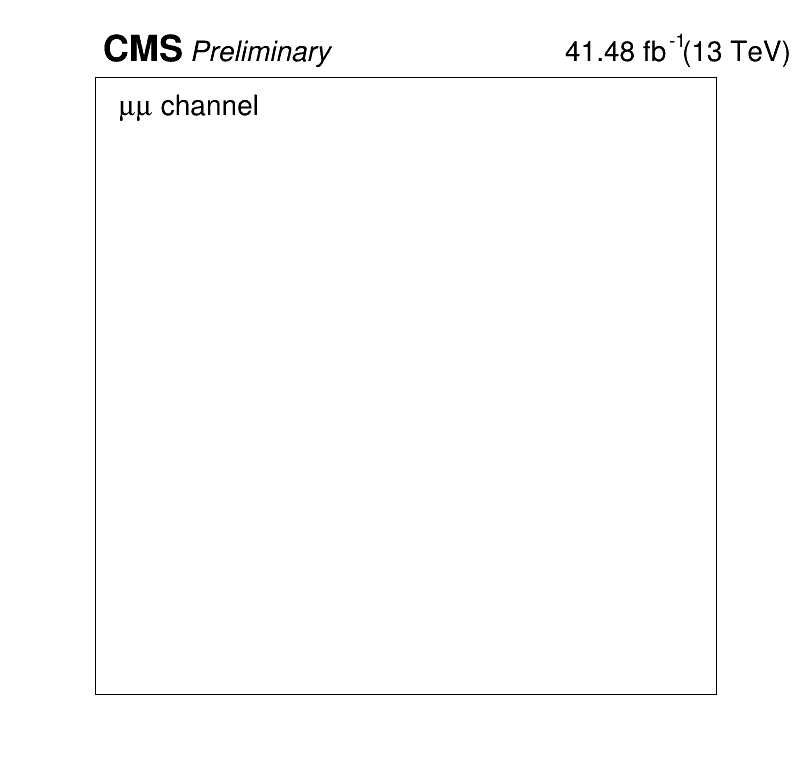

In [36]:
x = FloatVector([0.025, 0.075, 0.125, 0.175, 0.225, 0.275, 0.325, 0.375, 0.425, 0.475, 0.525, 0.575, 0.625, 0.675, 0.725, 0.775, 0.825, 0.875, 0.925, 0.975])
import math
for mass in masses:
    in_file = INPUTDIR+"/"+REGION+"/root_files/shape_v1_20230430wp80_ANv3"+mass+"_v1.root"
    out_file = out_dir+"/root_files/"+"shape_v1_20230430wp80_ANv3"+mass+"_smoothed_v1.root"
    os.system("cp "+in_file+" "+out_file)

    f = rt.TFile(in_file)

    rt.gDirectory.cd("signal_region")

    processes = ["ttbar", "ww", "zp"]
#     list_sys = get_sys_list()
#     list_sys.remove("scale")
#     list_sys = ["l1prefiring", "pu", "ll_eff", "met", "trig_eff", "toppt", "scale", "metue", "btagSF", "hdamp", "UE"]
    # 
    # temp! without btagsf
    # list_sys = ["l1prefiring", "pu", "effrecoSF", "ll_eff", "met", "trig_eff", "scale", "metue", "JEC", "JER", "metjer", "hdamp", "UE", "pdf", "muRF", "isr", "fsr"]
    
#     list_sys = ["scale"]
#     print(list_sys)
    for sys in list_sys:
        print(sys)
        c, dic_smooth = draw_sys_ratio_bysource(ERA, f, processes, sys, mass)
        if "met" in sys or "hdamp" in sys or "UE" in sys or "scale" in sys or "JEC" in sys or "isr" in sys or "fsr" in sys:          
            for process in processes:
                yup = FloatVector(dic_smooth[process+sys+'Up'])
                ydown = FloatVector(dic_smooth[process+sys+'Down'])
                n = dic_smooth[process+sys+'Nom']
                n1 = n
                if "scale" in sys and "e" in ERA:
                    n_data = dic_smooth[process+sys+'NomData']
                    n1 = n_data
                w = np.sqrt(n1)
                w = FloatVector(w)
                lup = limma.weightedLowess(x, yup, w, span=0.4, output_style="lowess")
                ldown = limma.weightedLowess(x, ydown, w, span=0.4, output_style="lowess")
                smoothed_up = np.array(lup[0])
                smoothed_up[np.isnan(smoothed_up)] = 1
                smoothed_down = np.array(ldown[0])
                smoothed_down[np.isnan(smoothed_down)] = 1
                print(process, n, yup, smoothed_up, smoothed_down)
                nbin = 20
                if "JEC" in sys:
                    h_Up = rt.TH1D(process+"_JESUp", process+"_JESUp", nbin, 0, 1)           
                    h_Down = rt.TH1D(process+"_JESDown", process+"_JESDown", nbin, 0, 1)                 
                elif "scale" in sys and "mm" in ERA:
                    h_Up_scale = rt.TH1D(process+"_mu_scale_smoothedUp", process+"_mu_scale_smoothedUp", nbin, 0, 1)           
                    h_Down_scale = rt.TH1D(process+"_mu_scale_smoothedDown", process+"_mu_scale_smoothedDown", nbin, 0, 1)                       
                    h_Up_res = rt.TH1D(process+"_mu_res_smoothedUp", process+"_mu_res_smoothedUp", nbin, 0, 1)           
                    h_Down_res = rt.TH1D(process+"_mu_res_smoothedDown", process+"_mu_res_smoothedDown", nbin, 0, 1)   
                else:               
                    h_Up = rt.TH1D(process+"_"+sys+"_smoothedUp", process+"_"+sys+"_smoothedUp", nbin, 0, 1)           
                    h_Down = rt.TH1D(process+"_"+sys+"_smoothedDown", process+"_"+sys+"_smoothedDown", nbin, 0, 1)           
                for nb in range(nbin):
                    # average
                    avg = (math.fabs(1-smoothed_up[nb])+math.fabs(1-smoothed_down[nb]))/2
                    h_Up.SetBinContent(nb+1, n[nb]*(1+avg))
                    h_Down.SetBinContent(nb+1, n[nb]*(1-avg))
                    if "scale" in sys and "mm" in ERA:
                        h_Up_scale.SetBinContent(nb+1, n[nb]*(1+math.fabs(1-smoothed_up[nb])))
                        h_Down_scale.SetBinContent(nb+1, n[nb]*(1-math.fabs(1-smoothed_up[nb])))                               
                        h_Up_res.SetBinContent(nb+1, n[nb]*(1+math.fabs(1-smoothed_down[nb])))
                        h_Down_res.SetBinContent(nb+1, n[nb]*(1-math.fabs(1-smoothed_down[nb])))                        
#                     print((avg))
#                     print((1-avg))
                write_sys_hist(out_file, h_Up, h_Down)
                if "scale" in sys and "mm" in ERA:
                    write_sys_hist(out_file, h_Up_scale, h_Down_scale)
                    write_sys_hist(out_file, h_Up_res, h_Down_res)


                

['l1prefiring', 'pu', 'effrecoSF', 'll_eff', 'met', 'trig_eff', 'metue', 'JEC', 'JER', 'metjer', 'hdamp', 'UE', 'mu_scale', 'mu_res', 'mu_scale', 'mu_res']
signal_region/ttbar_met_smoothedDown
signal_region/ww_met_smoothedDown
signal_region/zp_met_smoothedDown
signal_region/ttbar_metue_smoothedDown
signal_region/ww_metue_smoothedDown
signal_region/zp_metue_smoothedDown
signal_region/ttbar_metjer_smoothedDown
signal_region/ww_metjer_smoothedDown
signal_region/zp_metjer_smoothedDown
signal_region/ttbar_hdamp_smoothedDown
signal_region/ww_hdamp_smoothedDown
signal_region/zp_hdamp_smoothedDown
signal_region/ttbar_UE_smoothedDown
signal_region/ww_UE_smoothedDown
signal_region/zp_UE_smoothedDown
signal_region/ttbar_mu_scale_smoothedDown
signal_region/ww_mu_scale_smoothedDown
signal_region/zp_mu_scale_smoothedDown
signal_region/ttbar_mu_res_smoothedDown
signal_region/ww_mu_res_smoothedDown
signal_region/zp_mu_res_smoothedDown
signal_region/ttbar_mu_scale_smoothedDown
signal_region/ww_mu_scale

Info in <TCanvas::Print>: pdf file Outputs/Syst/mm17/SR/AN/Zp-2500_CH-345l1prefiring_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/mm17/SR/AN/Zp-2500_CH-345pu_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/mm17/SR/AN/Zp-2500_CH-345effrecoSF_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/mm17/SR/AN/Zp-2500_CH-345ll_eff_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/mm17/SR/AN/Zp-2500_CH-345met_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/mm17/SR/AN/Zp-2500_CH-345trig_eff_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/mm17/SR/AN/Zp-2500_CH-345metue_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/mm17/SR/AN/Zp-2500_CH-345JEC_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/mm17/SR/AN/Zp-2500_CH-345

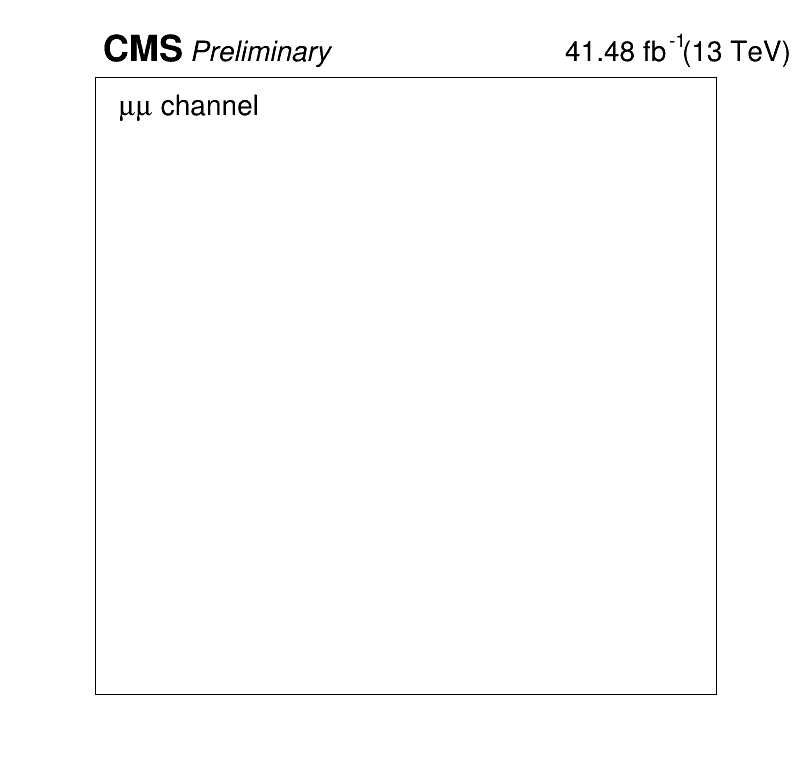

In [39]:
if "mm" in ERA:
    list_sys.remove("scale")
    list_sys += ["mu_scale", "mu_res"]
print(list_sys)

for mass in masses:
    out_file = out_dir+"/root_files/"+"shape_v1_20230430wp80_ANv3"+mass+"_smoothed_v1.root"

    f = rt.TFile(out_file)

    rt.gDirectory.cd("signal_region")
#     rt.gDirectory.ls()

    processes = ["ttbar", "ww", "zp"]
#     processes = ["ttbar"]
#     list_sys = ["l1prefiring", "pu", "ll_eff", "met", "trig_eff", "toppt", "scale", "metue", "btagSF", "hdamp", "UE"]
    # list_sys = ["l1prefiring", "pu", "effrecoSF", "ll_eff", "met", "trig_eff", "scale", "metue", "btagSF", "JEC", "JER", "metjer", "hdamp", "UE", "pdf", "muRF", "isr", "fsr"]
    # temp! without btagsf
#     list_sys = ["l1prefiring", "pu", "effrecoSF", "ll_eff", "met", "trig_eff", "scale", "metue", "JEC", "JER", "metjer", "hdamp", "UE", "pdf", "muRF", "isr", "fsr"]
    
#     list_sys = ["scale"]
    # temp
#     list_sys = ["mu_scale"]
#     list_sys = ["met"]
    for sys in list_sys:
        c, dic_smooth = draw_sys_ratio_bysource(ERA, f, processes, sys, mass, True)


 # Draw by process

ReferenceError: attempt to access a null-pointer

Info in <TCanvas::Print>: pdf file Outputs/Syst/mm17/SR/Zp-2500_CH-345ttbarUp_syst_by_process.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/mm17/SR/Zp-2500_CH-345ttbarDown_syst_by_process.pdf has been created


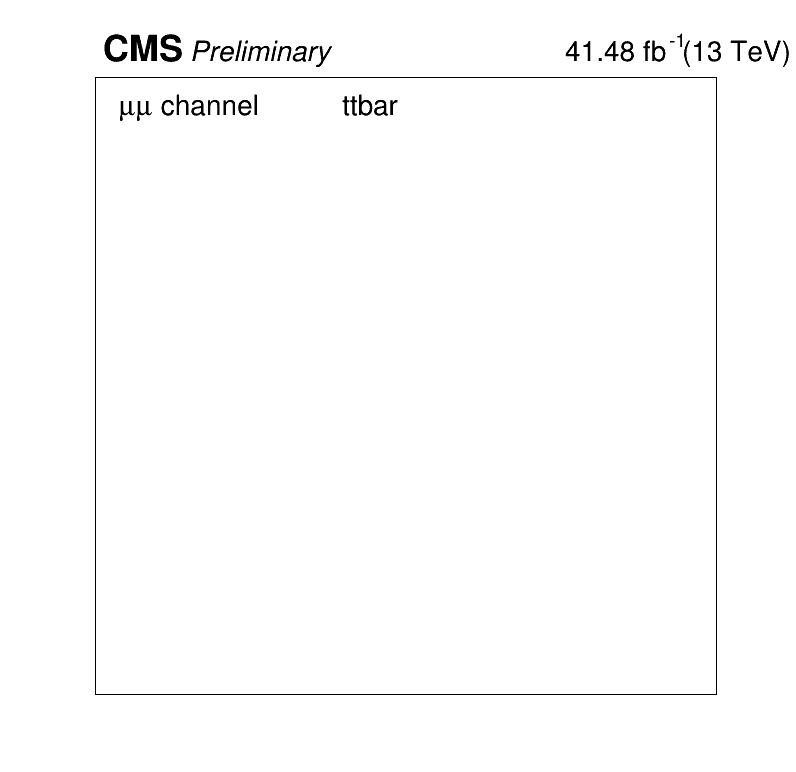

In [40]:
# for mass in masses:
#     out_file = out_dir+"/root_files/"+"shape_v1_20230430wp80_ANv3"+mass+"_smoothed_v1.root"

#     f = rt.TFile(out_file)

#     rt.gDirectory.cd("signal_region")

#     processes = ["ttbar", "ww", "zp"]
# #     processes = ["ttbar"]
# #     list_sys = ["l1prefiring", "pu", "ll_eff", "met", "trig_eff", "toppt", "scale", "metue", "btagSF", "hdamp", "UE"]
#     # list_sys = ["l1prefiring", "pu", "effrecoSF", "ll_eff", "met", "trig_eff", "scale", "metue", "btagSF"]
#     # temp! without btagsf
#     list_sys = ["l1prefiring", "pu", "effrecoSF", "ll_eff", "met", "trig_eff", "scale", "metue"]
#     for process in processes:
#         c = draw_sys_ratio(ERA, f, process, list_sys, mass, updown="Up", smoothed = False)        
#         c = draw_sys_ratio(ERA, f, process, list_sys, mass, updown="Down", smoothed = False)        
#         c = draw_sys_ratio(ERA, f, process, list_sys, mass, updown="Up", smoothed = True)        
#         c = draw_sys_ratio(ERA, f, process, list_sys, mass, updown="Down", smoothed = True)